### Part II- Some basic statistics
Using these codes you can find associations between differnt variables such as Age, Race, etc. It would be helpful in understanding the nature of the data before using it for further machine learning analysis. 

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

**For this part you will need the CSV files that you have created during the first part**. 

In [2]:
results_figuers_folder = "/content/drive/MyDrive/Colab_Notebooks/melanoma/melanoma_figs/"
location_of_data = "/content/drive/MyDrive/Colab_Notebooks/melanoma/"
mergedata2 = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/melanoma/mmergeddata2.csv")
original_clinical = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/melanoma/moriginal_clinical.csv")

**Chekc to see if the location of data and the files are correct**





In [3]:
mergedata2.head()

,Unnamed: 0,PATIENT_ID,COL1A2,EEF1A1,ACTB,AGE,RACE,TUMOR_STATUS,HEIGHT,WEIGHT,OS_MONTHS,SEX_x,SUBTYPE,SEX_y
0,0,TCGA-3N-A9WB,0.034788,0.242357,0.745607,71.0,WHITE,WITH TUMOR,175,78,17.02,Male,SKCM,Male
1,1,TCGA-3N-A9WC,0.051825,0.216978,0.691509,82.0,WHITE,WITH TUMOR,183,68,66.43,Male,SKCM,Male
2,2,TCGA-3N-A9WD,0.004643,0.065230,0.076481,82.0,WHITE,WITH TUMOR,183,116,12.98,Male,SKCM,Male
3,17,TCGA-BF-AAP0,0.287101,0.436468,1.000000,40.0,WHITE,TUMOR FREE,170,57,14.91,Female,SKCM,Female
4,18,TCGA-D3-A1Q1,0.047568,0.268395,0.146830,79.0,WHITE,WITH TUMOR,162,59,16.56,Female,SKCM,Female


**Functions for statistical annotations and box plot**

In [4]:
from matplotlib.text import Text
import matplotlib.pyplot as plt
from matplotlib import transforms, lines
import matplotlib.transforms as mtransforms
from matplotlib.font_manager import FontProperties
import numpy as np
import pandas as pd
import seaborn as sns
from seaborn.utils import remove_na

from scipy import stats


"""
This part of code has been adopted from https://github.com/webermarcolivier/statannot
"""

def stat_test(box_data1, box_data2, test):
    testShortName = ''
    formattedOutput = None
    if test == 'Mann-Whitney':
        u_stat, pval = stats.mannwhitneyu(box_data1, box_data2, alternative='two-sided')
        testShortName = 'M.W.W.'
        formattedOutput = "MWW RankSum two-sided P_val={:.3e} U_stat={:.3e}".format(pval, u_stat)
    elif test == 't-test_ind':
        stat, pval = stats.ttest_ind(a=box_data1, b=box_data2)
        testShortName = 't-test_ind'
        formattedOutput = "t-test independent samples, P_val={:.3e} stat={:.3e}".format(pval, stat)
    elif test == 't-test_paired':
        stat, pval = stats.ttest_rel(a=box_data1, b=box_data2)
        testShortName = 't-test_rel'
        formattedOutput = "t-test paired samples, P_val={:.3e} stat={:.3e}".format(pval, stat)

    return pval, formattedOutput, testShortName



def pvalAnnotation_text(x, pvalueThresholds):
    singleValue = False
    if type(x) is np.array:
        x1 = x
    else:
        x1 = np.array([x])
        singleValue = True
    # Sort the threshold array
    pvalueThresholds = pd.DataFrame(pvalueThresholds).sort_values(by=0, ascending=False).values
    xAnnot = pd.Series(["" for _ in range(len(x1))])
    for i in range(0, len(pvalueThresholds)):
        if (i < len(pvalueThresholds)-1):
            condition = (x1 <= pvalueThresholds[i][0]) & (pvalueThresholds[i+1][0] < x1)
            xAnnot[condition] = pvalueThresholds[i][1]
        else:
            condition = x1 < pvalueThresholds[i][0]
            xAnnot[condition] = pvalueThresholds[i][1]

    return xAnnot if not singleValue else xAnnot.iloc[0]


def add_stat_annotation(ax,
                        data=None, x=None, y=None, hue=None, order=None, hue_order=None,
                        boxPairList=None, 
                        test='Mann-Whitney', textFormat='star', loc='inside',
                        pvalueThresholds=[[1,"ns"], [0.0499,"*"], [1e-2,"**"], [1e-3,"***"], [1e-4,"****"]],
                        useFixedOffset=False, lineYOffsetToBoxAxesCoord=None, lineYOffsetAxesCoord=None,
                        lineHeightAxesCoord=0.02, textYOffsetPoints=1,
                        color='0.2', linewidth=1.5, fontsize='medium', verbose=1, ns=False, off_set=1.0):
    """
    User should use the same argument for the data, x, y, hue, order, hue_order as the seaborn boxplot function.

    boxPairList can be of either form:
    For non-grouped boxplot: [(cat1, cat2), (cat3, cat4)]
    For boxplot grouped by hue: [((cat1, hue1), (cat2, hue2)), ((cat3, hue3), (cat4, hue4))]
    """

    def find_x_position_box(boxPlotter, boxName):
        """
        boxName can be either a name "cat" or a tuple ("cat", "hue")
        """
        if boxPlotter.plot_hues is None:
            cat = boxName
            hueOffset = 0
        else:
            cat = boxName[0]
            hue = boxName[1]
            hueOffset = boxPlotter.hue_offsets[boxPlotter.hue_names.index(hue)]

        groupPos = boxPlotter.group_names.index(cat)
        boxPos = groupPos + hueOffset
        return boxPos


    def get_box_data(boxPlotter, boxName):

        """
        boxName can be either a name "cat" or a tuple ("cat", "hue")

        Here we really have to duplicate seaborn code, because there is not direct access to the
        box_data in the BoxPlotter class.
        """
        if boxPlotter.plot_hues is None:
            cat = boxName
        else:
            cat = boxName[0]
            hue = boxName[1]

        i = boxPlotter.group_names.index(cat)
        group_data = boxPlotter.plot_data[i]

        if boxPlotter.plot_hues is None:
            # Draw a single box or a set of boxes
            # with a single level of grouping
            box_data = remove_na(group_data)
        else:
            hue_level = hue
            hue_mask = boxPlotter.plot_hues[i] == hue_level
            box_data = remove_na(group_data[hue_mask])

        return box_data

    fig = plt.gcf()

    validList = ['inside', 'outside']
    if loc not in validList:
        raise ValueError("loc value should be one of the following: {}.".format(', '.join(validList)))
    validList = ['t-test_ind', 't-test_paired', 'Mann-Whitney']
    if test not in validList:
        raise ValueError("test value should be one of the following: {}.".format(', '.join(validList)))

    if verbose >= 1 and textFormat == 'star':
        print("pvalue annotation legend:")
        pvalueThresholds = pd.DataFrame(pvalueThresholds).sort_values(by=0, ascending=False).values
        for i in range(0, len(pvalueThresholds)):
            if (i < len(pvalueThresholds)-1):
                print('{}: {:.2e} < p <= {:.2e}'.format(pvalueThresholds[i][1], pvalueThresholds[i+1][0], pvalueThresholds[i][0]))
            else:
                print('{}: p <= {:.2e}'.format(pvalueThresholds[i][1], pvalueThresholds[i][0]))
        print()

    # Create the same BoxPlotter object as seaborn's boxplot
    boxPlotter = sns.categorical._BoxPlotter(x, y, hue, data, order, hue_order,
                                             orient=None, width=.8, color=None, palette=None, saturation=.75,
                                             dodge=True, fliersize=5, linewidth=None)
    plotData = boxPlotter.plot_data

    xtickslabels = [t.get_text() for t in ax.xaxis.get_ticklabels()]
    ylim = ax.get_ylim()
    yRange = ylim[1] - ylim[0]

    if lineYOffsetAxesCoord is None:
        if loc == 'inside':
            lineYOffsetAxesCoord = 0.05
            if lineYOffsetToBoxAxesCoord is None:
                lineYOffsetToBoxAxesCoord = 0.06
        elif loc == 'outside':
            lineYOffsetAxesCoord = 0.03
            lineYOffsetToBoxAxesCoord = lineYOffsetAxesCoord
    else:
        if loc == 'inside':
            if lineYOffsetToBoxAxesCoord is None:
                lineYOffsetToBoxAxesCoord = 0.06
        elif loc == 'outside':
            lineYOffsetToBoxAxesCoord = lineYOffsetAxesCoord
    yOffset = lineYOffsetAxesCoord*yRange
    yOffsetToBox = lineYOffsetToBoxAxesCoord*yRange

    yStack = []
    annList = []
    for box1, box2 in boxPairList:

        valid = None
        groupNames = boxPlotter.group_names
        hueNames = boxPlotter.hue_names
        if boxPlotter.plot_hues is None:
            cat1 = box1
            cat2 = box2
            hue1 = None
            hue2 = None
            label1 = '{}'.format(cat1)
            label2 = '{}'.format(cat2)
            valid = cat1 in groupNames and cat2 in groupNames
        else:
            cat1 = box1[0]
            hue1 = box1[1]
            cat2 = box2[0]
            hue2 = box2[1]
            label1 = '{}_{}'.format(cat1, hue1)
            label2 = '{}_{}'.format(cat2, hue2)
            valid = cat1 in groupNames and cat2 in groupNames and hue1 in hueNames and hue2 in hueNames


        if valid:
            # Get position of boxes
            x1 = find_x_position_box(boxPlotter, box1)
            x2 = find_x_position_box(boxPlotter, box2)
            box_data1 = get_box_data(boxPlotter, box1)
            box_data2 = get_box_data(boxPlotter, box2)
            ymax1 = off_set* np.quantile(box_data1,0.98)
            ymax2 =  off_set* np.quantile(box_data2, 0.98)

            pval, formattedOutput, testShortName = stat_test(box_data1, box_data2, test)
            if verbose >= 2: print ("{} v.s. {}: {}".format(label1, label2, formattedOutput))
            
            if ns or pval<=0.05:

                if textFormat == 'full':
                    text = "{} p < {:.2e}".format(testShortName, pval)
                elif textFormat is None:
                    text = None
                elif textFormat is 'star':
                    text = pvalAnnotation_text(pval, pvalueThresholds)

                if loc == 'inside':
                    yRef = max(ymax1, ymax2)
                elif loc == 'outside':
                    yRef = ylim[1]

                if len(yStack) > 0:
                    yRef2 = max(yRef, max(yStack))
                else:
                    yRef2 = yRef

                if len(yStack) == 0:
                    y = yRef2 + yOffsetToBox
                else:
                    y = yRef2 + 0.01* yOffset
                h = lineHeightAxesCoord*yRange
                lineX, lineY = [x1, x1, x2, x2], [y, y + h, y + h, y]
                if loc == 'inside':
                        ax.plot(lineX, lineY, lw=linewidth, c=color)
                elif loc == 'outside':
                        line = lines.Line2D(lineX, lineY, lw=linewidth, c=color, transform=ax.transData)
                        line.set_clip_on(False)
                        ax.add_line(line)


                if text is not None:
                    ann = ax.annotate(text, xy=(np.mean([x1, x2]), y + h),
                                      xytext=(0, textYOffsetPoints), textcoords='offset points',
                                      xycoords='data', ha='center', va='bottom', fontsize=fontsize,
                                      clip_on=False, annotation_clip=False)
                    annList.append(ann)

                ax.set_ylim((ylim[0], 1.1*(y + h)))

                if text is not None:
                    plt.draw()
                    yTopAnnot = None
                    gotMatplotlibError = False
                    if not useFixedOffset:
                        try:
                            bbox = ann.get_window_extent()
                            bbox_data = bbox.transformed(ax.transData.inverted())
                            yTopAnnot = bbox_data.ymax
                        except RuntimeError:
                            gotMatplotlibError = True

                    if useFixedOffset or gotMatplotlibError:
                        if verbose >= 1:
                            print("Warning: cannot get the text bounding box. Falling back to a fixed y offset. Layout may be not optimal.")
                        # We will apply a fixed offset in points, based on the font size of the annotation.
                        fontsizePoints = FontProperties(size='medium').get_size_in_points()
                        offsetTrans = mtransforms.offset_copy(ax.transData, fig=fig,
                                                              x=0, y=0.8*fontsizePoints + textYOffsetPoints, units='points')
                        yTopDisplay = offsetTrans.transform((0, y + h))
                        yTopAnnot = ax.transData.inverted().transform(yTopDisplay)[1]
                else:
                    yTopAnnot = y + h

                yStack.append(yTopAnnot)
        else:

            raise ValueError("boxPairList contains an unvalid box pair.")
            
            pass


    yStackMax = max(yStack)
    if loc == 'inside':
        ax.set_ylim((ylim[0], 1.03*yStackMax))
    elif loc == 'outside':
        ax.set_ylim((ylim[0], ylim[1]))

    return ax

In [5]:
def plot_box(data, x, y, hue, boxPairList_,x_label="" ,y_label="",x_position=None,y_position=None, c_label="",font_size=None,title="",figure_name="",hue_stat=True,palette=None,ns=False,order=None,hue_order=None,off_set =1.0):
    sns.set(rc={'figure.figsize':(9,9)})
    sns.set(style="white", color_codes=True)
    ax=sns.swarmplot(x=x,y=y,data=data, dodge=True, hue=hue,hue_order=hue_order,order=order,palette=palette)
    ax2=sns.boxplot(x= x ,y= y ,data= data, hue=hue, color='w',order=order)
    plt.xticks(rotation=0)

    # Get the handles and labels. For this example it'll be 2 tuples
    # of length 4 each.
    handles, labels = ax.get_legend_handles_labels()

    # When creating the legend, only use the first three elements
    # to effectively remove the last three.
    l = plt.legend(handles[3:], labels[3:])
    
    if hue_stat:
        add_stat_annotation(ax,data=data, x=x, y=y, hue=hue, ns= ns, useFixedOffset= False, off_set = off_set,
                        boxPairList=boxPairList_ , test='Mann-Whitney', textFormat='star',loc='inside',verbose=1)
    else:
        add_stat_annotation(ax,data=data, x=x, y=y, ns=ns, useFixedOffset=False, off_set =off_set,
                        boxPairList=boxPairList_ , test='Mann-Whitney', textFormat='star',loc='inside',verbose=1)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    ax.text(x=x_position, y=y_position,s=c_label,weight='bold',fontsize=font_size)

    plt.savefig(results_figuers_folder + figure_name,format='eps',bbox_inches='tight',dpi=1000)

    plt.show()

In [6]:
unique_clinical_values = mergedata2.nunique(axis=0)
print(unique_clinical_values)

Unnamed: 0      329
PATIENT_ID      327
COL1A2          326
EEF1A1          323
ACTB            314
AGE              68
RACE              3
TUMOR_STATUS      3
HEIGHT           36
WEIGHT           66
OS_MONTHS       316
SEX_x             2
SUBTYPE           1
SEX_y             2
dtype: int64


One can use the belwo code for making diffenrt comparson very simple but migth be informative

pvalue annotation legend:
ns: 4.99e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 4.99e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WITH TUMOR_Male v.s. WITH TUMOR_Female: MWW RankSum two-sided P_val=8.142e-01 U_stat=4.104e+03
WITH TUMOR_Male v.s. TUMOR FREE_Female: MWW RankSum two-sided P_val=8.831e-03 U_stat=4.274e+03
WITH TUMOR_Female v.s. TUMOR FREE_Male: MWW RankSum two-sided P_val=3.122e-01 U_stat=2.933e+03
TUMOR FREE_Female v.s. TUMOR FREE_Male: MWW RankSum two-sided P_val=9.610e-02 U_stat=1.816e+03
TUMOR FREE_Female v.s. WITH TUMOR_Female: MWW RankSum two-sided P_val=9.163e-03 U_stat=1.288e+03
TUMOR FREE_Male v.s. WITH TUMOR_Male: MWW RankSum two-sided P_val=3.744e-01 U_stat=4.767e+03


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


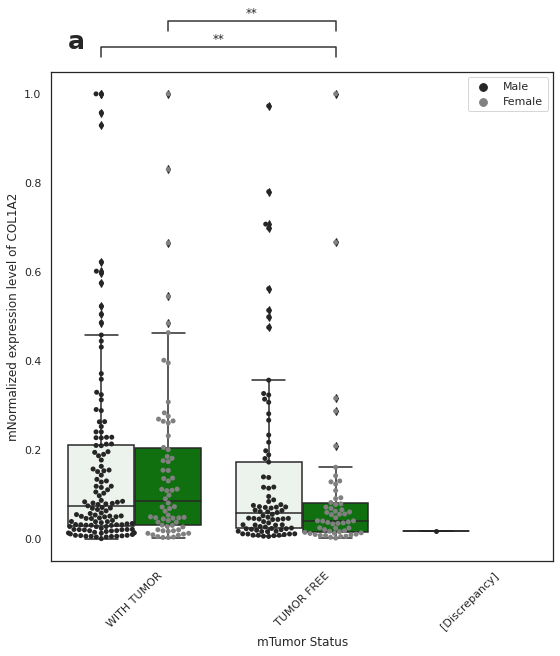

In [7]:
# Manual drawing a boxplot- when there is some data without counterparts.
sns.set(rc={'figure.figsize':(9,9)})
sns.set(style="white", color_codes=True)
ax=sns.boxplot(x="TUMOR_STATUS",y="COL1A2",data=mergedata2,hue="SEX_x",color='green')
sns.swarmplot(x="TUMOR_STATUS",y="COL1A2",data=mergedata2,hue="SEX_x" ,dodge=True,color="grey")

plt.xticks(rotation=45)

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[2:], labels[2:])


add_stat_annotation(ax,data=mergedata2,hue='SEX_x',x="TUMOR_STATUS",y='COL1A2',boxPairList=[(("WITH TUMOR","Male"),("WITH TUMOR","Female")),(("WITH TUMOR", "Male"),("TUMOR FREE", "Female")),(("WITH TUMOR", "Female"),("TUMOR FREE", "Male")),(("TUMOR FREE", "Female"),("TUMOR FREE", "Male")),(("TUMOR FREE", "Female"),("WITH TUMOR", "Female")),(("TUMOR FREE", "Male"),("WITH TUMOR", "Male"))],test='Mann-Whitney',textFormat='star',loc='outside',verbose=2)


plt.xlabel('mTumor Status')
plt.ylabel('mNormalized expression level of COL1A2')
ax.text(-0.4, 1.10,"a",weight='bold',fontsize=25)
plt.savefig(results_figuers_folder +'xtumor_col1a2.eps',format='eps',bbox_inches='tight',dpi=1000)

plt.show()